In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import kerastuner
import tensorflow
import pandas as pd

from tensorflow import keras


from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdMolDescriptors, QED

from keras.optimizers import Adam
from sklearn import datasets, metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from tensorflow.keras.layers import Embedding, Dense,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K 
from tensorflow.keras import initializers

In [ ]:
inp = pd.read_csv('Total_dataset.csv')
train_df = inp.iloc[452:,:].reset_index(drop=True)
test_df = inp.iloc[:452,:]
train_s = train_df.iloc[:,:-1]
train_t = train_df['toxicity']
test_s = test_df.iloc[:,:-1]
test_t = test_df['toxicity']

In [4]:
inp.groupby('toxicity')['ref'].value_counts()

toxicity  ref     
0         Liew        337
          DILIrank    268
          NCTR        179
          Greene       80
          Xu           34
1         Liew        438
          DILIrank    184
          NCTR        169
          Greene      149
          Xu           12
Name: ref, dtype: int64

# Train

In [ ]:
# smiles 
smiles_list = []
for i in range(len(train_df)):
    train_df['smiles'][i] = str(train_df['smiles'][i])

# mol to smiles
mols = [Chem.MolFromSmiles(smiles) for smiles in train_df["smiles"]]

# if mol isn't transform to smiles, to none_list
none_list = []
for i in range(len(mols)):
    if mols[i] is None :
        none_list.append(i)
        print('add to none_list')
    
reg_idx = 0
for i in none_list :
    del mols[i - reg_idx]
    reg_idx += 1
    
# modify index
if len(none_list) != 0 :
    train_df = train_df.drop(none_list, axis=0)
    train_df = train_df.reset_index(drop = True)

In [9]:
train_df['toxicity'].value_counts()

1    768
0    630
Name: toxicity, dtype: int64

In [10]:
# create fingerprint 
bit_info_list = [] 
bit_info = {} 
fps = []

b = 0

# mol to fingerprint Bit Vector
for a in mols :
    fps.append(AllChem.GetMorganFingerprintAsBitVect(a, 3, nBits = 1024, bitInfo = bit_info))
    bit_info_list.append(bit_info.copy()) 
    
# to array
arr_list = list()
for i in range(len(fps)):
    array = np.zeros((0,), dtype = np.int8)
    arr_list.append(array)
    
for i in range(len(fps)):
    bit = fps[i]
    DataStructs.ConvertToNumpyArray(bit, arr_list[i])
    
x = np.stack([i.tolist() for i in arr_list])
x = x.astype(np.float32)
finprt = pd.DataFrame(x)

In [11]:
# physicochemical properties

qe = [QED.properties(mol) for mol in mols]
qe = pd.DataFrame(qe)
qe

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,211.217,0.44230,5,4,103.78,3,1,1
1,357.793,3.92732,4,1,68.53,5,3,1
2,273.741,1.61550,3,0,54.45,1,1,0
3,414.527,3.36850,6,0,59.08,6,2,1
4,268.273,-0.98900,6,4,112.13,2,1,0
...,...,...,...,...,...,...,...,...
1393,1069.238,-4.34170,16,13,437.91,19,2,4
1394,943.090,0.04230,19,9,282.21,10,0,2
1395,578.662,4.16250,9,1,108.55,7,3,1
1396,556.792,6.76220,4,0,59.08,15,2,2


In [13]:
#QED datapreprocessing 
ss = StandardScaler()

ss.fit(qe)
qe_scaled = ss.transform(qe) 


qe_scaled = pd.DataFrame(qe_scaled)
qe_scaled.columns =['MW','ALOGP','HBA','HBD','PSA','ROTB','AROM','ALERTS']
qe_scaled

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,-0.769322,-0.669906,-0.019260,0.733783,0.213807,-0.463486,-0.413202,-0.009528
1,-0.022689,0.682270,-0.266282,-0.435030,-0.237935,-0.034662,1.403327,-0.009528
2,-0.450835,-0.214709,-0.513305,-0.824635,-0.418376,-0.892310,-0.413202,-0.897540
3,0.266304,0.465449,0.227762,-0.824635,-0.359040,0.179750,0.495062,-0.009528
4,-0.478688,-1.225246,0.227762,0.733783,0.320815,-0.677898,-0.413202,-0.897540
...,...,...,...,...,...,...,...,...
1393,3.601285,-2.526083,2.697986,4.240223,4.495807,2.967107,0.495062,2.654509
1394,2.958710,-0.825105,3.439053,2.681805,2.500453,1.037399,-1.321466,0.878484
1395,1.102378,0.773519,0.968830,-0.435030,0.274936,0.394162,1.403327,-0.009528
1396,0.990976,1.782194,-0.266282,-0.824635,-0.359040,2.109459,0.495062,0.878484


In [14]:
from pickle import dump

#dump(ss, open('./standard_scaler.pkl','wb'))

In [ ]:
final = pd.concat([finprt,qe_scaled,train_t],axis=1)
x_train = final.iloc[:,:1032]
y_train = final['toxicity']

## Test 

In [ ]:
# smiles 
smiles_list = []
for i in range(len(test_df)):
    test_df['smiles'][i] = str(test_df['smiles'][i])

# to mol 
mols = [Chem.MolFromSmiles(smiles) for smiles in test_df["smiles"]]

# if smiles don't transform to mol, add to none_list 
none_list = []
for i in range(len(mols)):
    if mols[i] is None :
        none_list.append(i)
        print('add to none_list')
    
reg_idx = 0
for i in none_list :
    del mols[i - reg_idx]
    reg_idx += 1
    
# modify index
if len(none_list) != 0 :
    test_df = test_df.drop(none_list, axis=0)
    test_df = test_df.reset_index(drop = True)


# create fingerprint 
bit_info_list = [] 
bit_info = {} 
fps = []

b = 0

# mol to fingerprint Bit Vector 
for a in mols :
    fps.append(AllChem.GetMorganFingerprintAsBitVect(a, 3, nBits = 1024, bitInfo = bit_info))
    bit_info_list.append(bit_info.copy())
    
# to array 
arr_list = list()
for i in range(len(fps)):
    array = np.zeros((0,), dtype = np.int8)
    arr_list.append(array)
    
for i in range(len(fps)):
    bit = fps[i]
    DataStructs.ConvertToNumpyArray(bit, arr_list[i])
    
x = np.stack([i.tolist() for i in arr_list])
x = x.astype(np.float32)
finprt = pd.DataFrame(x)

In [19]:
# physicochemical properties

qe = [QED.properties(mol) for mol in mols]
qe = pd.DataFrame(qe)
qe

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,444.423,0.98202,8,3,150.02,6,2,3
1,234.202,2.77710,3,1,48.14,1,2,0
2,1202.635,3.26900,12,5,278.80,15,0,1
3,242.274,3.66700,3,1,46.53,4,2,0
4,222.251,-0.85610,5,2,115.04,2,1,1
...,...,...,...,...,...,...,...,...
447,473.446,-0.73110,11,7,219.84,10,2,1
448,497.525,-3.30790,11,5,208.43,9,2,1
449,527.526,1.02890,11,5,185.84,4,3,1
450,926.107,0.77830,18,12,327.45,3,0,1


In [24]:
from pickle import load 

#QED datapreprocessing 
load_ss = load(open('./standard_scaler.pkl','rb'))
qe_scaled = load_ss.transform(qe)
qe_scaled = pd.DataFrame(qe_scaled, columns=['MW','ALOGP','HBA','HBD','PSA','ROTB','AROM','ALERTS'])
qe_scaled

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,0.418589,-0.460497,0.721807,0.344178,0.806389,0.179750,0.495062,1.766496
1,-0.652240,0.235988,-0.513305,-0.435030,-0.499241,-0.892310,0.495062,-0.897540
2,4.280786,0.426844,1.709897,1.123387,2.456753,2.109459,-1.321466,-0.009528
3,-0.611123,0.581266,-0.513305,-0.435030,-0.519873,-0.249074,0.495062,-0.897540
4,-0.713116,-1.173681,-0.019260,-0.045426,0.358108,-0.677898,-0.413202,-0.009528
...,...,...,...,...,...,...,...,...
447,0.566427,-1.125182,1.462874,1.902596,1.701159,1.037399,0.495062,-0.009528
448,0.689081,-2.124972,1.462874,1.123387,1.554935,0.822986,0.495062,-0.009528
449,0.841900,-0.442308,1.462874,1.123387,1.265436,-0.249074,1.403327,-0.009528
450,2.872202,-0.539540,3.192031,3.850618,3.080221,-0.463486,-1.321466,-0.009528


In [ ]:
final = pd.concat([finprt,qe_scaled,test_t],axis=1)
x_test = final.iloc[:,:1032]
y_test = final['toxicity']

# Model train

In [23]:
x = x_train
y = y_train

In [ ]:
# split train validation set 

x_train, x_val, y_train,y_val = train_test_split(x,y,train_size=0.8, random_state=42)


In [ ]:
# input data dimension
input_dim = x_train.shape[1]

# Layer weight initializers 
initializer = tf.keras.initializers.HeNormal()

# L2 regularizer 
from tensorflow.keras import regularizers
regularizer = regularizers.l2(0.001)

#model hyperparameter
epochs = 100
batch_size = 32

#callbacks
callbacks = [
    tensorflow.keras.callbacks.ModelCheckpoint(
        "DILIattention.h5", save_best_only=True, monitor="val_loss"
    ),
    tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),
]

In [140]:
# PregTaboo
from keras.layers import Dense, Dropout, MultiHeadAttention

# Model
inputs = tf.keras.layers.Input(shape=(input_dim,))
dense_v = tf.keras.layers.Dense(input_dim, activation = None)(inputs)
attn_score = tf.keras.layers.Softmax(axis = -1)(dense_v)
cal_score = tf.math.multiply(inputs, attn_score)
Dense1 = tf.keras.layers.Dense(512, activation = 'relu', 
                          kernel_initializer = initializer)(cal_score)
Dense1_BN = tf.keras.layers.BatchNormalization()(Dense1)
Dropout = Dropout(rate=0.25)(Dense1_BN)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(Dropout)

In [141]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1032)]       0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 1032)         1066056     input_11[0][0]                   
__________________________________________________________________________________________________
softmax_10 (Softmax)            (None, 1032)         0           dense_30[0][0]                   
__________________________________________________________________________________________________
tf.math.multiply_10 (TFOpLambda (None, 1032)         0           input_11[0][0]                   
                                                                 softmax_10[0][0]          

In [142]:


model.compile(
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    )
    
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data = (x_val, y_val),
    callbacks = callbacks
    )

Epoch 1/100


C:\Users\lab\anaconda3\envs\my-rdkit-env\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


35/35 [==============================] - 1s 11ms/step - loss: 0.6845 - accuracy: 0.5492 - val_loss: 0.6892 - val_accuracy: 0.5429
Epoch 2/100
35/35 [==============================] - 0s 9ms/step - loss: 0.6011 - accuracy: 0.6959 - val_loss: 0.6843 - val_accuracy: 0.5429
Epoch 3/100
35/35 [==============================] - 0s 8ms/step - loss: 0.4184 - accuracy: 0.8041 - val_loss: 0.6796 - val_accuracy: 0.5500
Epoch 4/100
35/35 [==============================] - 0s 8ms/step - loss: 0.2649 - accuracy: 0.8828 - val_loss: 0.6703 - val_accuracy: 0.6000
Epoch 5/100
35/35 [==============================] - 0s 8ms/step - loss: 0.1877 - accuracy: 0.9177 - val_loss: 0.6719 - val_accuracy: 0.5607
Epoch 6/100
35/35 [==============================] - 0s 9ms/step - loss: 0.1071 - accuracy: 0.9678 - val_loss: 0.6620 - val_accuracy: 0.6107
Epoch 7/100
35/35 [==============================] - 0s 8ms/step - loss: 0.0799 - accuracy: 0.9705 - val_loss: 0.6632 - val_accuracy: 0.5964
Epoch 8/100
35/35 [=====

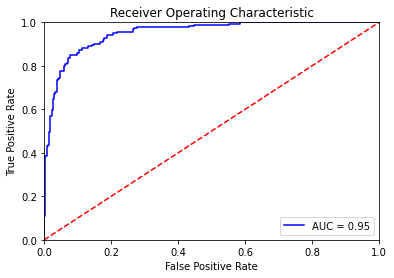

In [144]:
# ROC curve
from sklearn.metrics import roc_auc_score,roc_curve,auc
preds = model.predict(x_test) #x_test: DILIrank dataset

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

roc = pd.DataFrame({
    'FPR': fpr,
    'TPRate': tpr,
    'Threshold': threshold
})

optimal_idx=np.argmax(tpr-fpr)
optimal_threshold= threshold[optimal_idx]


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

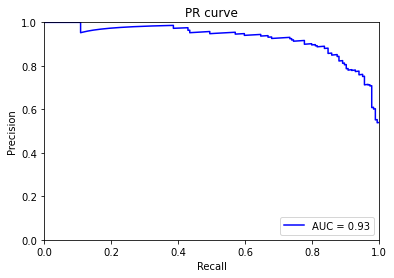

In [147]:
from sklearn.metrics import precision_recall_curve

# precision, recall, threshold 
precision, recall, thresholds = precision_recall_curve(y_test, preds)
# pr_auc 
pr_auc = auc(recall, precision)
# F1 score 
F1 = 2*(precision*recall)/(precision+recall)

plt.title('PR curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [149]:
d_t = pd.DataFrame(y_test)
d_t = d_t.reset_index(drop=True)
d_preds = pd.DataFrame(preds)
pred_proba = pd.concat([d_t,d_preds],axis=1)
pred_proba.columns=['toxicity','prediction']
pred_proba.sort_values(by='prediction',ascending=False)
preds_1d = preds.flatten()
pred_class = np.where(preds_1d> optimal_threshold,1,0)

In [198]:
print('idx:',optimal_idx,', threshold:',optimal_threshold )

auc_score = roc_auc_score(y_test, preds)
accuracy_score = accuracy_score(y_test,pred_class)
Precision = precision_score(y_test,pred_class)
Recall = recall_score(y_test,pred_class)
print('AUC:',auc_score)
F1_score = 2*(Precision*Recall)/(Precision+Recall)

idx: 42 , threshold: 0.5802659
AUC: 0.9511680726800779


In [199]:
# model performance
test_preds = model.predict(x_test)

test_preds[test_preds >= optimal_threshold] = 1
test_preds[test_preds < optimal_threshold] = 0

Precision = precision_score(y_test, test_preds)
Recall = recall_score(y_test, test_preds)
model_roc = model.predict(x_test)
F1_score = 2*(Precision*Recall)/(Precision+Recall)

print('accuracy : {0}'.format(accuracy_score(y_test, test_preds)))
print('Precision : {0}'.format(Precision))
print('Recall : {0}'.format(Recall))
print('ROC_score : {0}'.format(roc_auc_score(y_test, model_roc)))
print("F1 score : {0}".format(F1_score))

accuracy : 0.8871681415929203
Precision : 0.8518518518518519
Recall : 0.875
ROC_score : 0.9511680726800779
F1 score : 0.8632707774798928


In [200]:
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
specificity = tn / (tn+fp)
specificity

0.8955223880597015